<div style="background-color: lightblue; padding: 50px; text-align: center; font-size: 30px; margin: 50px auto; width: 60%; border-radius: 10px;">
Classification 
</div>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import os
from PIL import Image

2025-09-07 18:41:53.107122: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757270513.388802      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757270513.483602      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset_dir='/kaggle/input/microsoft-catsvsdogs-dataset/PetImages'
class_names=os.listdir(dataset_dir) # story dog and cat in class_names

In [3]:
class_to_index={name:i for i,name in enumerate(class_names)} #make dictionary for classes

In [4]:
class_to_index

{'Dog': 0, 'Cat': 1}

In [5]:
class_to_index['Dog'] # check if give class name give me number or what

0

In [6]:
images = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    for file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, file)  # get path for each image
        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize((150, 150))
            img_array = np.array(img, dtype=np.float32) / 255  # normalize
            images.append(img_array)
            labels.append(class_to_index[class_name])  # corrected
        except Exception as e:
            print(f'Error loading {img_path}: {e}')


images = np.array(images)
labels = np.array(labels)

print(f"Number of images: {images.shape}")
print(f"Number of labels: {labels.shape}")


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Error loading /kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/11702.jpg: cannot identify image file '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/11702.jpg'
Error loading /kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/Thumbs.db: cannot identify image file '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/Thumbs.db'
Error loading /kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/Thumbs.db: cannot identify image file '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/Thumbs.db'
Error loading /kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/666.jpg: cannot identify image file '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/666.jpg'
Number of images: (24998, 150, 150, 3)
Number of labels: (24998,)


## check data balanced

In [7]:
_,counts=np.unique(labels,return_counts=True)

<Axes: >

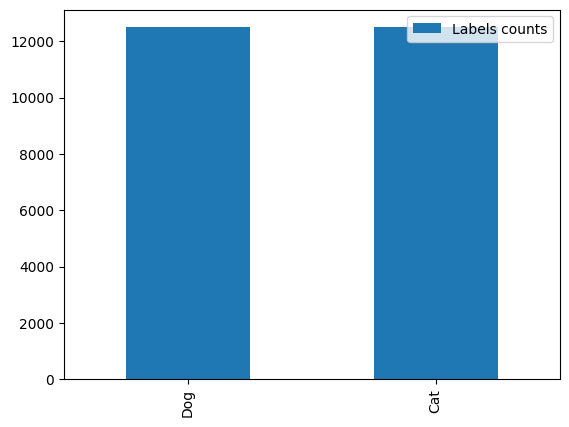

In [8]:
pd.DataFrame({'Labels counts':counts},index=class_to_index).plot.bar()

([<matplotlib.patches.Wedge at 0x7ef520f54410>,
 [Text(6.735557395310444e-17, 1.1, 'Dog'),
  Text(-2.0206672185931328e-16, -1.1, 'Cat')],
 [Text(3.6739403974420595e-17, 0.6, '50.0%'),
  Text(-1.1021821192326178e-16, -0.6, '50.0%')])

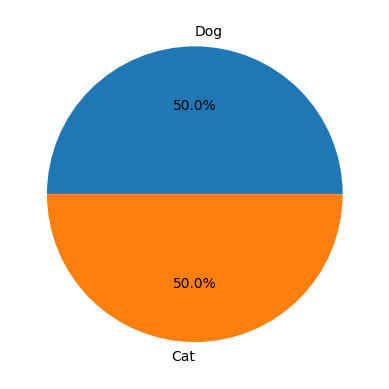

In [9]:
plt.pie(counts,explode=(0,0),labels=class_to_index,autopct="%1.1f%%")

### so data is balanced

## Print some image before preprocessing

In [10]:
index_to_class = {v: k for k, v in class_to_index.items()}

In [11]:
index_to_class

{0: 'Dog', 1: 'Cat'}

In [12]:
import random

In [13]:
def display_images(images,labels,n=10):
    for i in range(n):
        idx=random.randint(0,len(images)-1)
        plt.imshow(images[idx])
        plt.title(f"Label:{index_to_class[labels[idx]]}")
        plt.axis('off')
        plt.show()

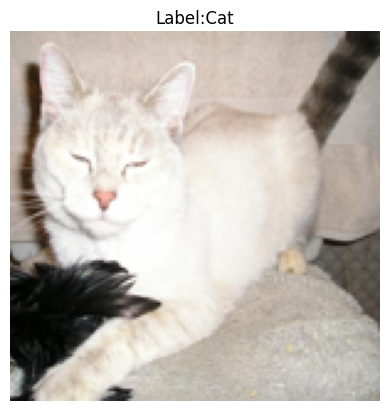

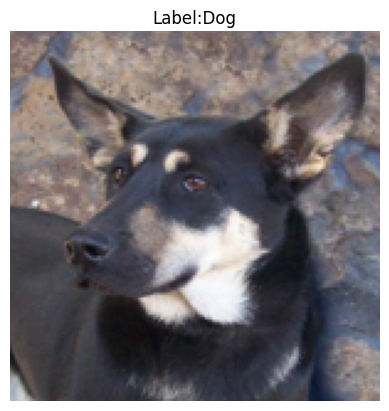

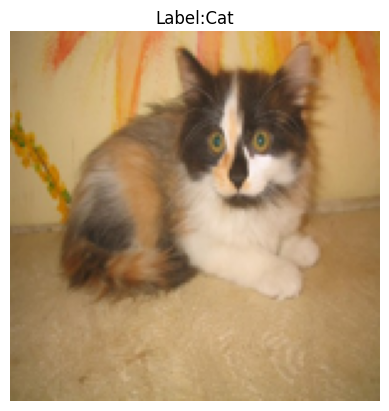

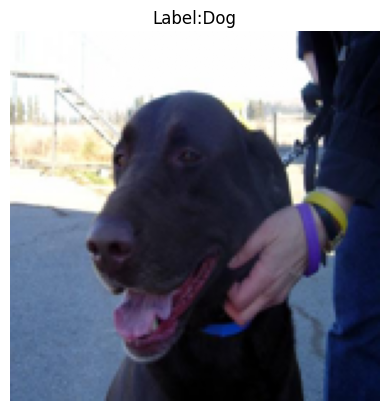

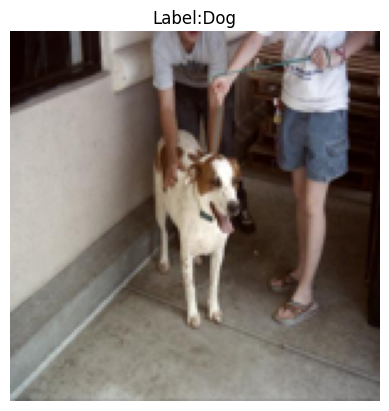

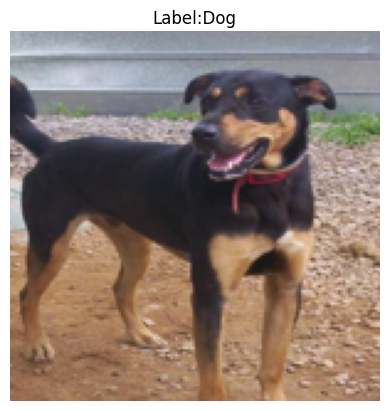

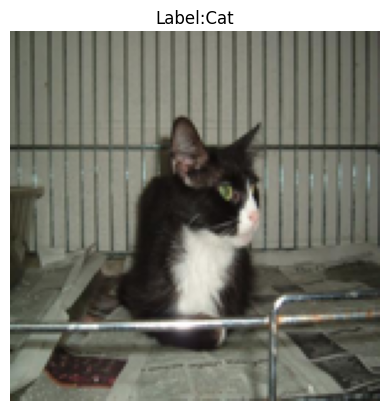

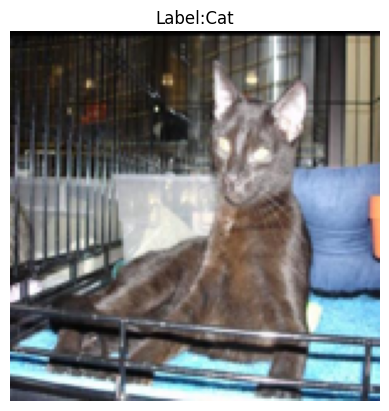

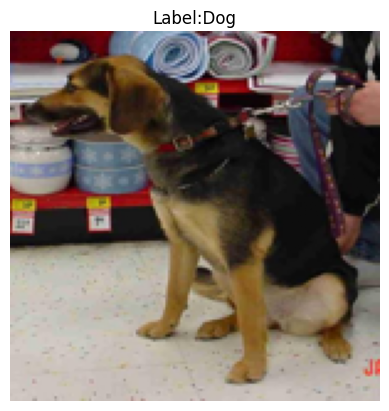

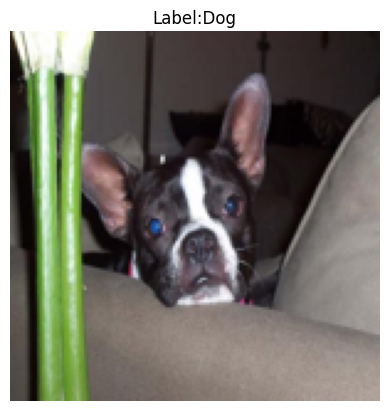

In [14]:
display_images(images,labels,10)

## Split The Data & shuffle it

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, shuffle=True, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, stratify=y_temp, random_state=42)


In [17]:
print(f"train data size: {X_train.shape}")
print(f"train data size: {y_train.shape}")
print('*'*60)
print(f"validation data size: {X_val.shape}")
print(f"validation data size: {y_val.shape}")
print('*'*60)
print(f"test data size: {X_test.shape}")
print(f"test data size: {y_test.shape}")

train data size: (17498, 150, 150, 3)
train data size: (17498,)
************************************************************
validation data size: (3750, 150, 150, 3)
validation data size: (3750,)
************************************************************
test data size: (3750, 150, 150, 3)
test data size: (3750,)


## Augmented the data

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [19]:
train_datagen=ImageDataGenerator(
    rotation_range=20,
    width_shift_range=.1,
    height_shift_range=.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='reflect'
    
)
val_datagen=ImageDataGenerator()
test_datagen=ImageDataGenerator()

In [20]:
train_generator=train_datagen.flow(X_train,y_train,batch_size=32)
Val_generator=val_datagen.flow(X_val,y_val,batch_size=32)
test_generator=test_datagen.flow(X_test,y_test,batch_size=32)

## show image and its augmentation

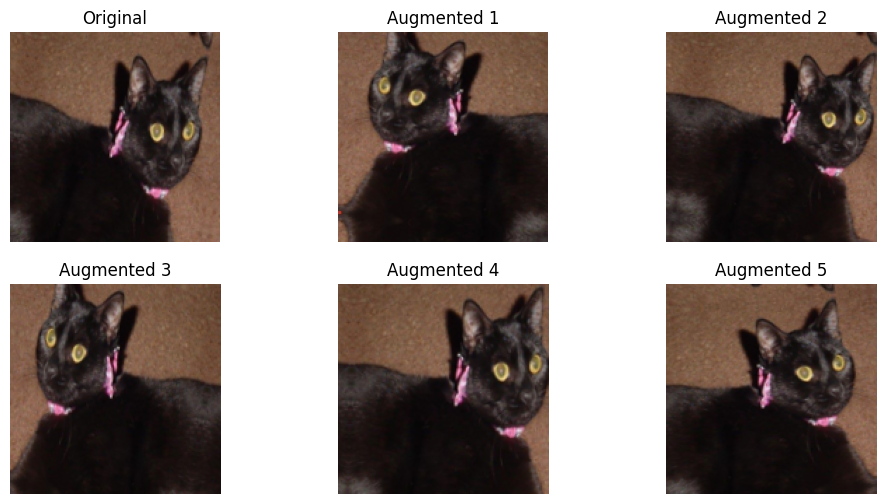

In [21]:
idx = random.randint(0, len(X_train) - 1) # get random number
img = X_train[idx]


img_batch = np.expand_dims(img, 0) # imageDataGenerator expect (-,-,-,-)


aug_iter = train_datagen.flow(img_batch, batch_size=1) #generate one augmented img


plt.figure(figsize=(12,6))
for i in range(6):  
    batch = next(aug_iter)                    # make second augmentation
    aug_img = batch[0]                  #remove batch dimention
    plt.subplot(2, 3, i+1)
    plt.imshow(aug_img)
    plt.axis('off')
    if i == 0:
        plt.title("Original")
    else:
        plt.title(f"Augmented {i}")
plt.show()

## Built CNN Model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout


In [23]:
X_train.shape

(17498, 150, 150, 3)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from tensorflow.keras.layers import GlobalAveragePooling2D, LeakyReLU

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1757270812.046795      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757270812.047413      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## Train the model

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=Val_generator,
    epochs=30,
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1757270818.679263      65 service.cc:148] XLA service 0x7ef184087660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757270818.680376      65 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757270818.680400      65 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757270819.224442      65 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/547 ━━━━━━━━━━━━━━━━━━━━ 1:35:03 10s/step - accuracy: 0.3125 - loss: 0.9713

I0000 00:00:1757270824.315625      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


547/547 ━━━━━━━━━━━━━━━━━━━━ 94s 153ms/step - accuracy: 0.6006 - loss: 0.6998 - val_accuracy: 0.5797 - val_loss: 0.7230
Epoch 2/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 78s 143ms/step - accuracy: 0.6963 - loss: 0.5811 - val_accuracy: 0.6840 - val_loss: 0.6042
Epoch 3/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 78s 142ms/step - accuracy: 0.7593 - loss: 0.4993 - val_accuracy: 0.8141 - val_loss: 0.4356
Epoch 4/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 78s 143ms/step - accuracy: 0.8151 - loss: 0.4117 - val_accuracy: 0.7512 - val_loss: 0.5449
Epoch 5/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 77s 141ms/step - accuracy: 0.8561 - loss: 0.3304 - val_accuracy: 0.8667 - val_loss: 0.3015
Epoch 6/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 78s 142ms/step - accuracy: 0.8795 - loss: 0.2748 - val_accuracy: 0.8851 - val_loss: 0.2706
Epoch 7/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 77s 141ms/step - accuracy: 0.8977 - loss: 0.2444 - val_accuracy: 0.8419 - val_loss: 0.3513
Epoch 8/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 78s 142ms/step - accuracy: 0.9053 - loss: 0.2231 - val

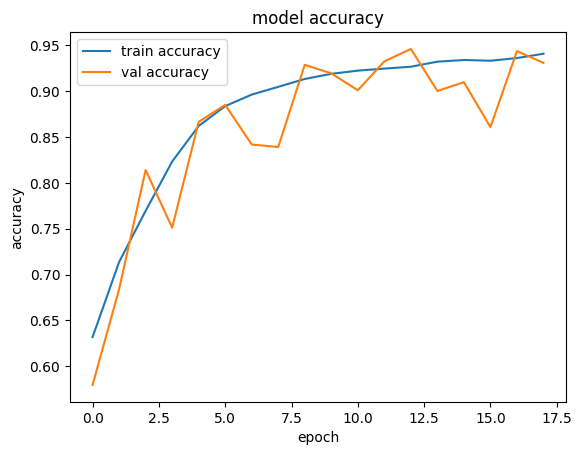

In [26]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Model Evaluation

In [27]:
model.evaluate(train_generator)

547/547 ━━━━━━━━━━━━━━━━━━━━ 75s 137ms/step - accuracy: 0.9467 - loss: 0.1320


[0.13369417190551758, 0.9474225640296936]

In [28]:
loss, accuracy = model.evaluate(Val_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9434 - loss: 0.1376
Validation Loss: 0.1372
Validation Accuracy: 0.9461


In [29]:
loss, accuracy = model.evaluate(test_generator)
print(f"test Loss: {loss:.4f}")
print(f"test Accuracy: {accuracy:.4f}")


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9375 - loss: 0.1571
test Loss: 0.1642
test Accuracy: 0.9333


In [30]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred_prop=model.predict(test_generator)
y_pred=(y_pred_prop>0.5).astype(int)
y_true=y_test

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


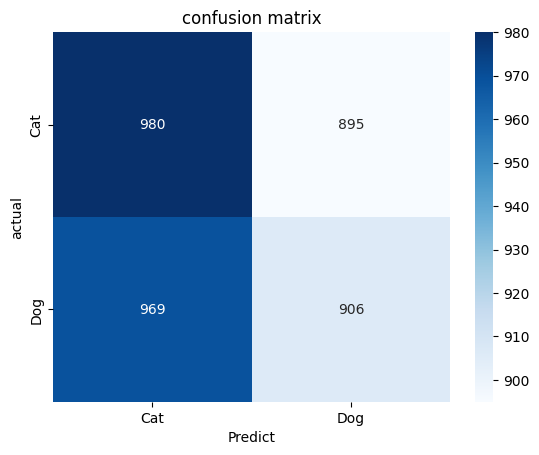

In [31]:
cm=confusion_matrix(y_true,y_pred)
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=['Cat','Dog'],yticklabels=['Cat','Dog'])
plt.xlabel('Predict')
plt.ylabel('actual')
plt.title('confusion matrix')
plt.show()

In [32]:
cr=classification_report(y_true,y_pred)

In [33]:
print(cr)

              precision    recall  f1-score   support

           0       0.50      0.52      0.51      1875
           1       0.50      0.48      0.49      1875

    accuracy                           0.50      3750
   macro avg       0.50      0.50      0.50      3750
weighted avg       0.50      0.50      0.50      3750



## Save model

In [34]:
from tensorflow.keras.models import load_model

In [35]:

model.save("/kaggle/working/cat_dog_model.keras")




<div style="background-color: lightblue; padding: 50px; text-align: center; font-size: 30px; margin: 50px auto; width: 60%; border-radius: 10px;">
Thanks 
</div>
